In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from eda import EDA

In [2]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
eda = EDA()

In [4]:
eda.load_data(
    main_path="../data/processed/ethiopia_fi_unified_data_enriched.csv",
    impacts_path="../data/processed/ethiopia_fi_impact_links_enriched.csv"
)

Loaded main dataset with shape (49, 34)
Loaded impacts dataset with shape (17, 35)


In [5]:
eda.preprocess_data()

Preprocessing complete: dates and numeric fields converted.


### Dataset Overview

We start by examining the main dataset across **record types**, **pillars**, and **source types**.


In [6]:
# Record type distribution
record_type_counts = eda.summarize_by('record_type')
print(record_type_counts)

# Pillar distribution
pillar_counts = eda.summarize_by('pillar')
print(pillar_counts)

# Source type distribution
source_counts = eda.summarize_by('source_type')
print(source_counts)


record_type
observation    33
event          13
target          3
Name: count, dtype: int64
pillar
ACCESS           17
USAGE            13
NaN              13
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64
source_type
operator            15
survey              10
regulator            7
research             4
policy               3
secondary_report     3
calculated           2
news                 2
official             2
media                1
Name: count, dtype: int64


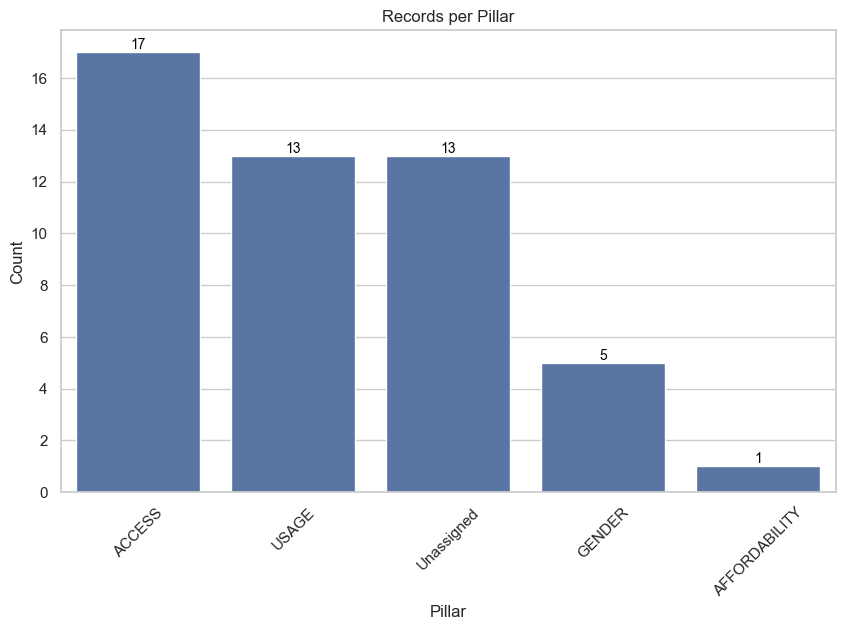

In [7]:
eda.main['pillar_plot'] = eda.main['pillar'].fillna('Unassigned')

sns.countplot(data=eda.main, x='pillar_plot', order=eda.main['pillar_plot'].value_counts().index)
plt.title("Records per Pillar")
plt.ylabel("Count")
plt.xlabel("Pillar")
plt.xticks(rotation=45)

# Annotate bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=10, color='black')

plt.show()

### Temporal Coverage

We check which **years have data for which indicators**.


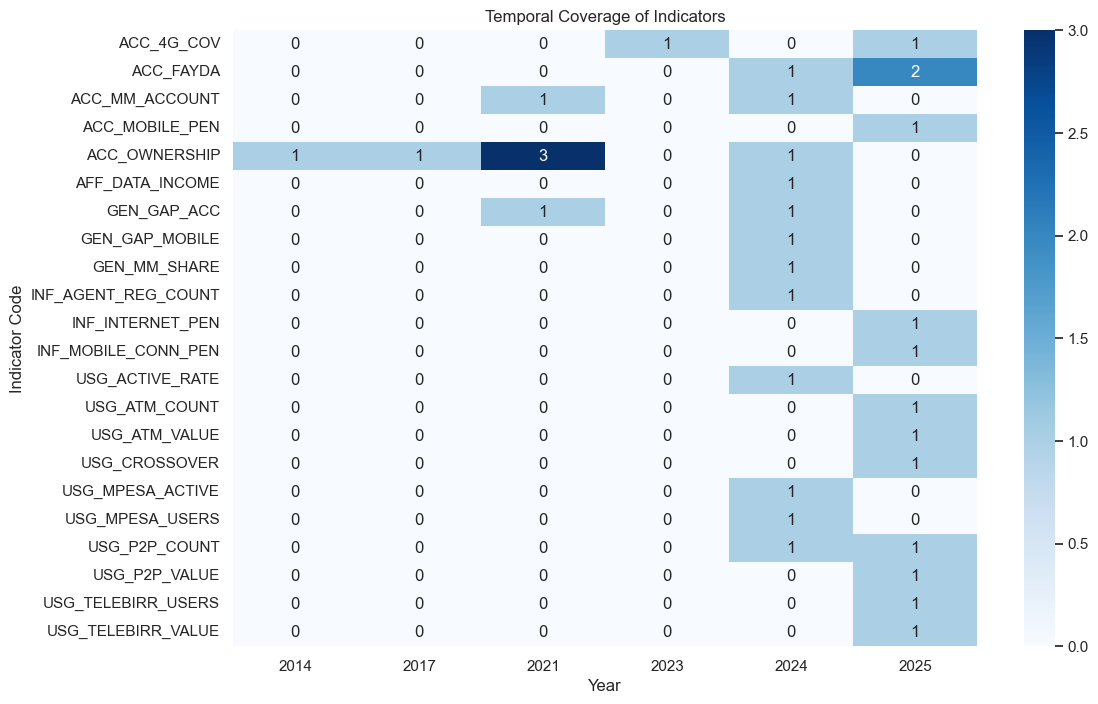

In [8]:
coverage = eda.temporal_coverage()
coverage_heatmap = coverage.copy()

plt.figure(figsize=(12,8))
sns.heatmap(coverage_heatmap, annot=True, fmt="d", cmap="Blues")
plt.title("Temporal Coverage of Indicators")
plt.ylabel("Indicator Code")
plt.xlabel("Year")
plt.show()


### Data Quality Assessment

We examine the **confidence level distribution** to assess data reliability.


confidence
high      42
medium     7
Name: count, dtype: int64


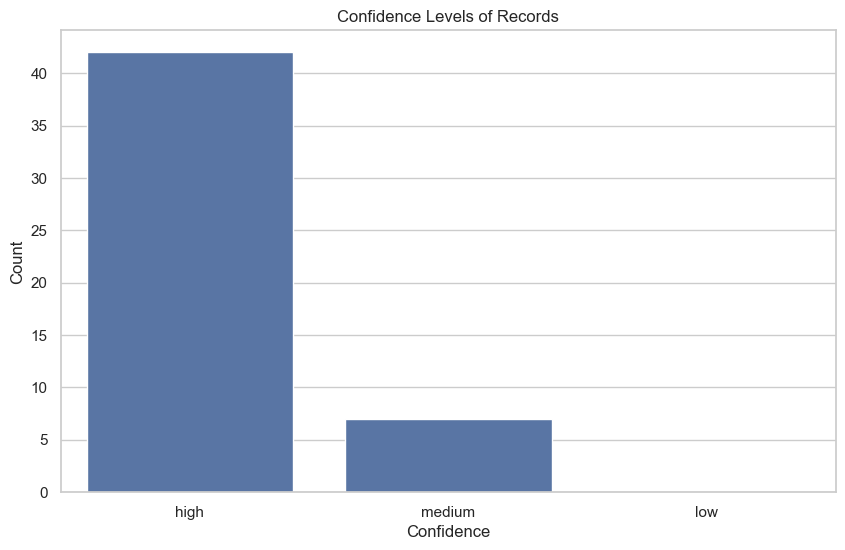

In [9]:
conf_counts = eda.confidence_distribution()
print(conf_counts)

sns.countplot(data=eda.main, x='confidence', order=['high','medium','low'])
plt.title("Confidence Levels of Records")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.show()


### Sparse Indicators

Indicators with very few observations are identified to highlight **data gaps**.


In [10]:
sparse_indicators = eda.identify_sparse_indicators(min_count=2)
print("Sparse indicators:\n", sparse_indicators)


Sparse indicators:
 indicator_code
ACC_MOBILE_PEN         1
USG_P2P_VALUE          1
USG_ATM_COUNT          1
USG_ATM_VALUE          1
USG_CROSSOVER          1
USG_TELEBIRR_USERS     1
USG_TELEBIRR_VALUE     1
USG_MPESA_USERS        1
USG_MPESA_ACTIVE       1
USG_ACTIVE_RATE        1
AFF_DATA_INCOME        1
GEN_MM_SHARE           1
GEN_GAP_MOBILE         1
INF_INTERNET_PEN       1
INF_MOBILE_CONN_PEN    1
INF_AGENT_REG_COUNT    1
Name: count, dtype: int64


### Access Analysis

We focus on Ethiopia's **account ownership trajectory**.

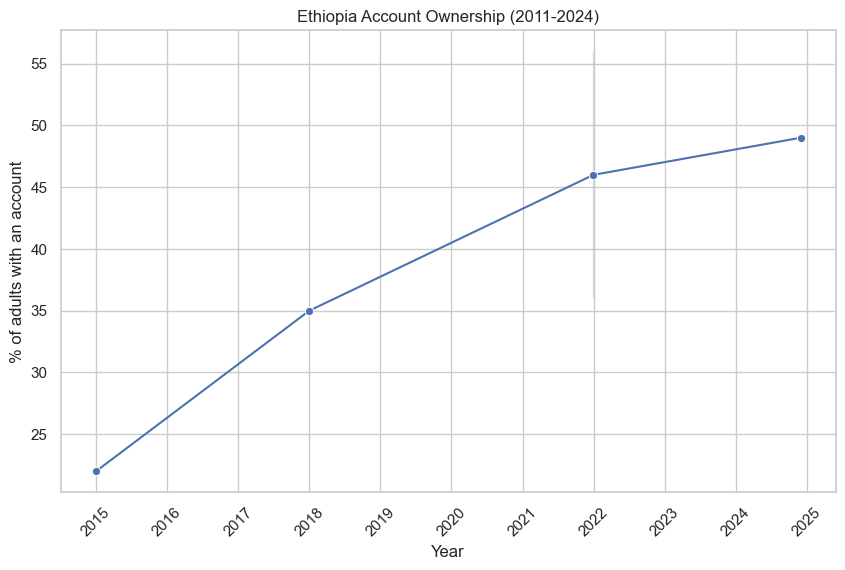

In [11]:
# Filter for account ownership observations
account_obs = eda.filter_records(record_type='observation')
account_obs = account_obs[account_obs['indicator_code'] == 'ACC_OWNERSHIP']

# Plot trajectory
sns.lineplot(data=account_obs, x='observation_date', y='value_numeric', marker='o')
plt.title("Ethiopia Account Ownership (2011-2024)")
plt.ylabel("% of adults with an account")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.show()

### Growth Rates Between Survey Years

In [12]:
account_obs_sorted = account_obs.sort_values('observation_date')
account_obs_sorted['growth_pp'] = account_obs_sorted['value_numeric'].diff()
print(account_obs_sorted[['observation_date','value_numeric','growth_pp']])


  observation_date  value_numeric  growth_pp
0       2014-12-31           22.0        NaN
1       2017-12-31           35.0       13.0
2       2021-12-31           46.0       11.0
3       2021-12-31           56.0       10.0
4       2021-12-31           36.0      -20.0
5       2024-11-29           49.0       13.0


### Gender and Urban/Rural Gaps (if available)

Currently, disaggregated data is limited. Placeholder for gender and location analyses.


### 2021-2024 Slowdown

Account ownership grew only +3pp despite massive mobile money expansion. 
Potential explanations could include:

- Large proportion of previously unbanked adults reached early by mobile money
- Barriers in account usage or KYC compliance
- Limited effect of newly registered accounts on survey-based ownership

### Usage (Digital Payments) Analysis

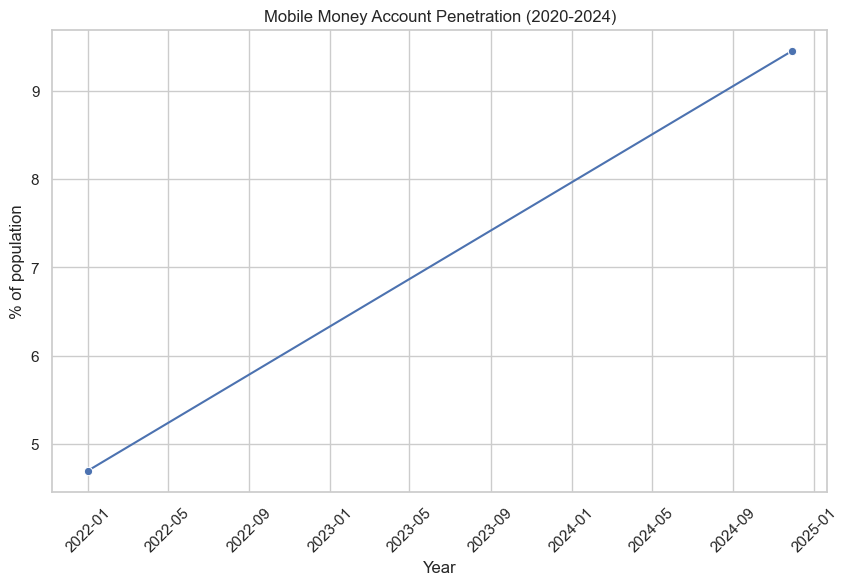

In [13]:
usage_obs = eda.filter_records(record_type='observation')
mobile_money_accounts = usage_obs[usage_obs['indicator_code'] == 'ACC_MM_ACCOUNT'].copy()

# Make sure observation_date is datetime
mobile_money_accounts['observation_date'] = pd.to_datetime(mobile_money_accounts['observation_date'])

# Filter years 2014 to 2024
mobile_money_accounts = mobile_money_accounts[
    (mobile_money_accounts['observation_date'].dt.year >= 2011) &
    (mobile_money_accounts['observation_date'].dt.year <= 2024)
]

plt.figure(figsize=(10,6))
sns.lineplot(data=mobile_money_accounts, x='observation_date', y='value_numeric', marker='o')
plt.title("Mobile Money Account Penetration (2020-2024)")
plt.ylabel("% of population")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()




### Registered vs Active Accounts & Payment Use Cases

Additional data could support exploring gaps between **registered** and **active** accounts and the **P2P, merchant, bill pay, wages** usage patterns.

### Infrastructure and Enablers

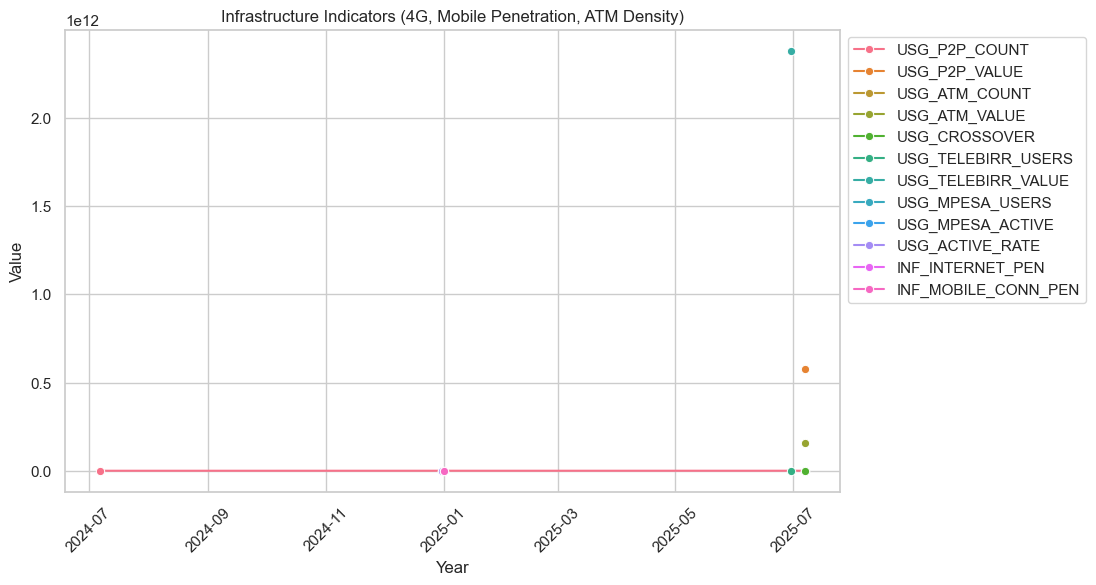

In [14]:
# Example: Mobile penetration
infrastructure_obs = eda.filter_records(record_type='observation')
infrastructure_obs = infrastructure_obs[infrastructure_obs['pillar'] == 'USAGE']

sns.lineplot(data=infrastructure_obs, x='observation_date', y='value_numeric', hue='indicator_code', marker='o')
plt.title("Infrastructure Indicators (4G, Mobile Penetration, ATM Density)")
plt.ylabel("Value")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1,1))
plt.show()


### Event Timeline and Visual Analysis

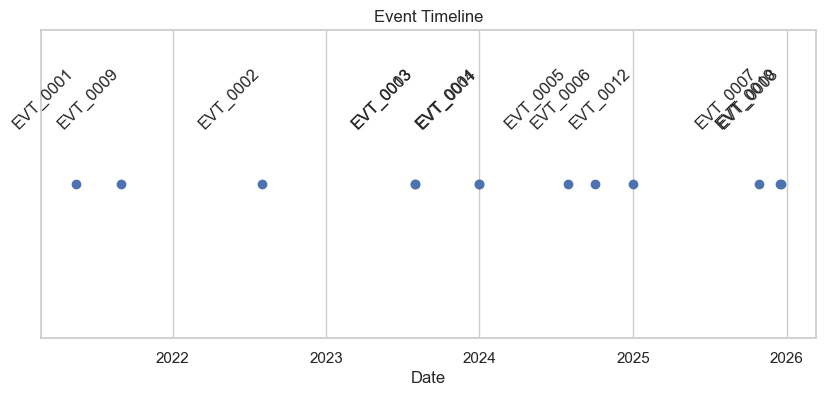

In [15]:
# Merge impact links for timeline
impact_full = eda.merge_impacts()

# Plot timeline of events
events = eda.filter_records(record_type='event')
events_sorted = events.sort_values('observation_date')

plt.figure(figsize=(10,4))
plt.scatter(events_sorted['observation_date'], [1]*len(events_sorted), marker='o')
for i, row in events_sorted.iterrows():
    plt.text(row['observation_date'], 1.02, row['record_id'], rotation=45, ha='right')
plt.yticks([])
plt.title("Event Timeline")
plt.xlabel("Date")
plt.show()


### Overlay Events on Account Ownership

This visualization helps identify relationships, e.g.:

- Telebirr launch (May 2021)
- Safaricom market entry (Aug 2023)

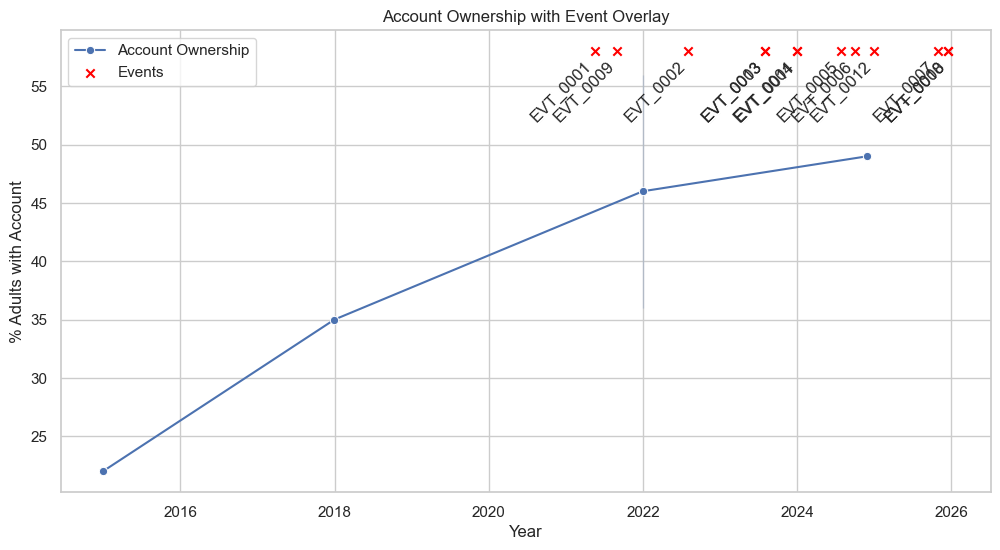

In [16]:
plt.figure(figsize=(12,6))
sns.lineplot(data=account_obs, x='observation_date', y='value_numeric', marker='o', label='Account Ownership')
plt.scatter(events_sorted['observation_date'], [account_obs['value_numeric'].max()+2]*len(events_sorted),
            color='red', label='Events', marker='x')
for i, row in events_sorted.iterrows():
    plt.text(row['observation_date'], account_obs['value_numeric'].max()-4, row['record_id'], rotation=45, ha='right')
plt.title("Account Ownership with Event Overlay")
plt.ylabel("% Adults with Account")
plt.xlabel("Year")
plt.legend()
plt.show()

### Correlation Analysis

We examine correlations between indicators to identify factors strongly associated with **Access** and **Usage**.


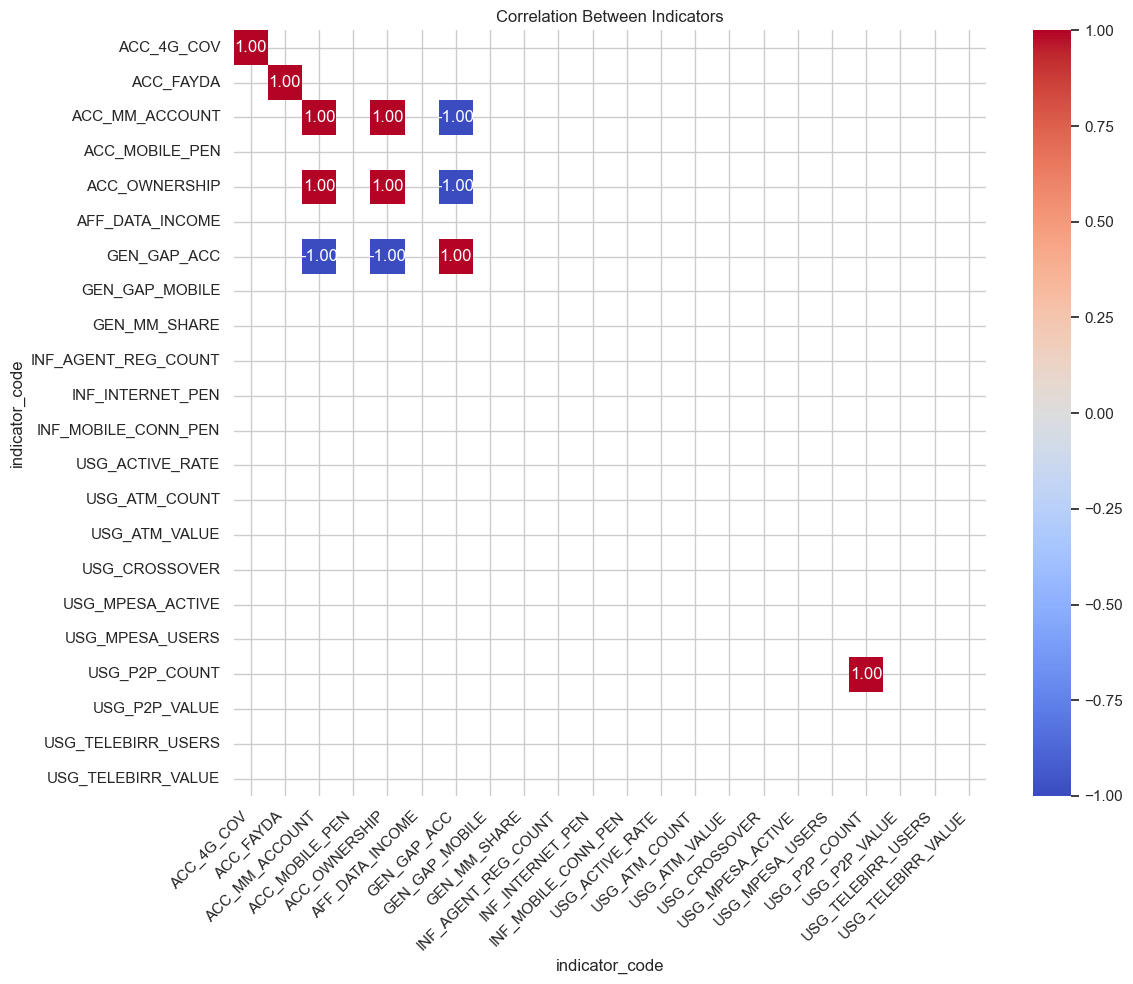

In [17]:
# Filter only observations
obs = eda.main[eda.main['record_type']=='observation']

# Pivot using mean to handle duplicates
obs_numeric = obs.pivot_table(
    index='observation_date',
    columns='indicator_code',
    values='value_numeric',
    aggfunc='mean'  # averages duplicates
)

# Compute correlation matrix
corr_matrix = obs_numeric.corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Between Indicators")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Key Insights

1. **Account Ownership Growth:** Ethiopia saw +3pp growth from 2021-2024 despite millions of mobile money accounts, suggesting usage barriers limit impact.  
2. **Mobile Money Expansion:** Digital payment adoption steadily increased, aligned with infrastructure improvements and new entrants (Telebirr, Safaricom).  
3. **Sparse Data:** Several indicators (e.g., gender-disaggregated data, payment use cases) have very few observations, limiting detailed insights.  
4. **Infrastructure Drivers:** Mobile penetration, agent density, and interoperability events appear correlated with usage and access metrics.  
5. **Event Impacts:** Major events like Telebirr launch (2021) and Safaricom entry (2023) coincide with observable accelerations in digital payment adoption.  


### Data Limitations

- Disaggregated data by gender and location is sparse.  
- Some indicators are only reported irregularly, limiting trend analysis.  
- Survey-based account ownership may lag behind mobile money registrations.  


### Hypotheses for Impact Modeling

- Infrastructure improvements (mobile penetration, agent density) are leading indicators of account usage.  
- Policy interventions (Fayda Digital ID) positively affect account ownership.  
- Market entry events accelerate digital payment adoption in urban centers first.  
